In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import os
import matplotlib.pyplot as plt
from itertools import compress
import calfews_src
# from read_hdf5_output import get_results_sensitivity_number
from calfews_src import *
from calfews_src.visualizer import Visualizer
from calfews_src.util import *
import seaborn as sns

from make_financial_data_km import analyze_correlation_between_pumping_and_revenue
from make_financial_data_km import analyze_correlation_between_pumping_and_revenue_historical
import importlib
import make_financial_data_km
importlib.reload(make_financial_data_km)


<module 'make_financial_data_km' from 'c:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS_waterFutures\\make_financial_data_km.py'>

In [5]:
# districts = [
#     'kerndelta', 'wheeler', 'westkern', 'belridge', 
#     'berrenda', 'semitropic', 'rosedale', 'buenavista', 
#     'cawelo', 'henrymiller', 'losthills'
# ]

# years_to_include = 3

# results = {}
# for district in districts:
#     x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)
#     # Store or print the results as needed
#     results[district] = (x, y)
#     print(f"District: {district}, X: {x}, Y: {y}")

In [ ]:
# districts = [
#     'kerndelta', 'wheeler', 'westkern', 'belridge', 
#     'berrenda', 'semitropic', 'rosedale', 'buenavista', 
#     'cawelo', 'henrymiller', 'losthills'
# ]

# data_frames = []
# for district in districts:
#     file_name = f"plots/pumping_vs_revenue_{district}_3yr.csv"
#     df = pd.read_csv(file_name, usecols=['Year', 'Simulation', 'Total Pumping', 'Annual Revenue'])
#     df.rename(columns={'Annual Revenue': f'Annual Revenue {district}'}, inplace=True)
#     data_frames.append(df)

# # Merge all dataframes on 'Year', 'Simulation', 'Total Pumping'
# combined_df = data_frames[0]
# for df in data_frames[1:]:
#     combined_df = combined_df.merge(df, on=['Year', 'Simulation', 'Total Pumping'], how='outer')

# # Sum up the 'Annual Revenue' columns
# revenue_columns = [f'Annual Revenue {district}' for district in districts]
# combined_df['Total Annual Revenue'] = combined_df[revenue_columns].sum(axis=1)

# combined_df.to_csv("plots/pumping_vs_revenue_KCWA_3yr.csv", index=False, columns=['Year', 'Simulation', 'Total Pumping', 'Total Annual Revenue'])

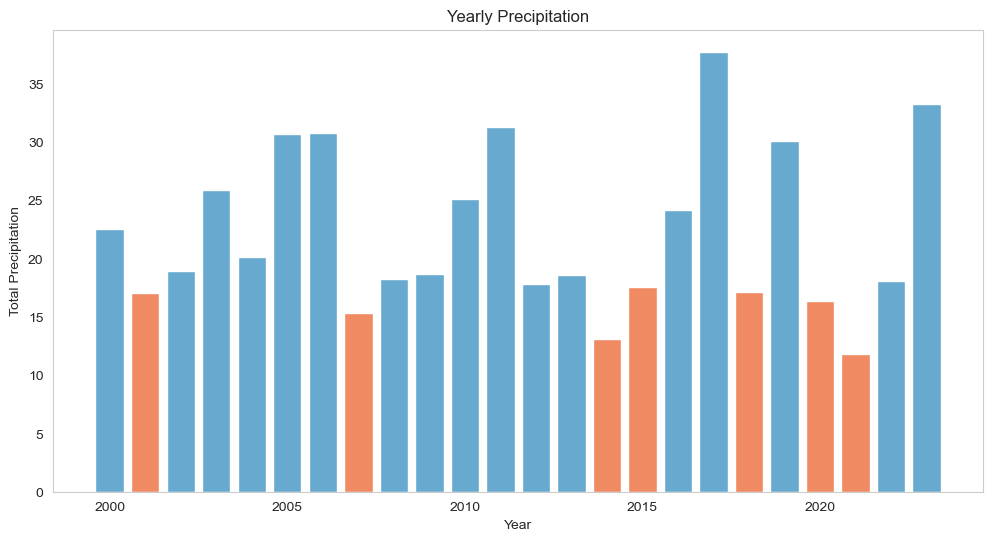

In [2]:
df = pd.read_csv('calfews_src/data/price_index/data-BEa5S.csv')
df['Year'] = pd.to_datetime(df['Year'], format='%Y').dt.year
df = df[(df['Year'] >= 2000)]
average_precipitation = df['Precipitation (inches)'].mean()
threshold = 0.8 * average_precipitation

plt.figure(figsize=(12, 6))

# Use a for loop to plot each bar conditionally
colors = []
for value in df['Precipitation (inches)']:
    if value < threshold:
        colors.append('#ef8a62')
    else:
        colors.append('#67a9cf')

plt.bar(df['Year'], df['Precipitation (inches)'], color=colors, alpha = 1)
plt.title('Yearly Precipitation')
plt.xlabel('Year')
plt.ylabel('Total Precipitation')
plt.grid(False)

# Add a legend
# plt.legend(['Below trigger'], loc='upper right')

plt.show()

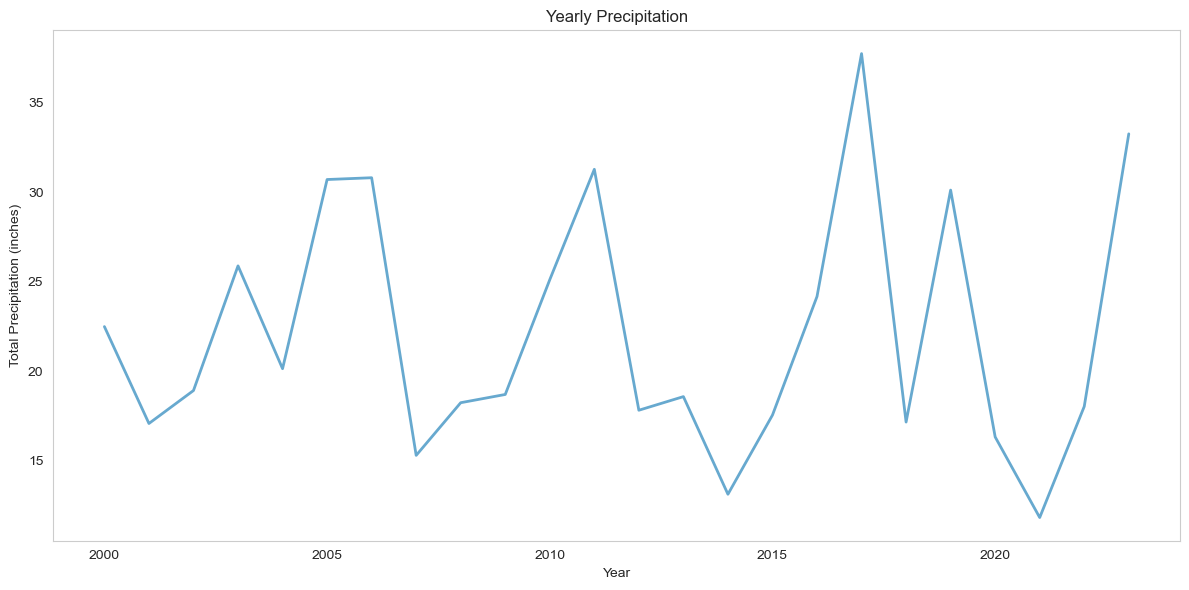

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Precipitation (inches)'], color='#67a9cf', linewidth=2, label='Precipitation')

# Highlight points below threshold
# below_threshold = df['Precipitation (inches)'] < threshold
# plt.scatter(df['Year'][below_threshold], df['Precipitation (inches)'][below_threshold],
#             color='#ef8a62', label='Below 80% Threshold', zorder=5)
# plt.axhline(threshold, color='gray', linestyle='--', linewidth=1, label='80% of Mean')

# Add labels and title
plt.title('Yearly Precipitation')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (inches)')
# plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Basis risk examination

Text(0.5, 1.0, 'Annual Revenue')

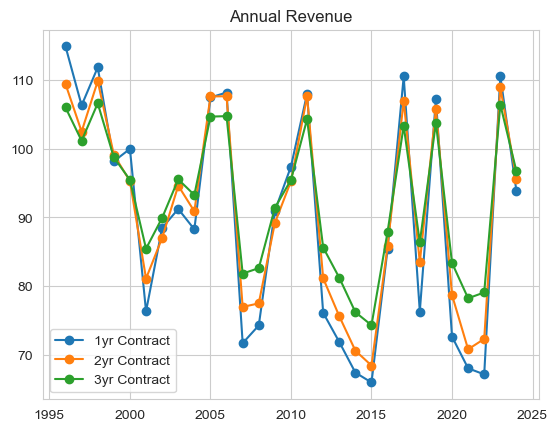

In [2]:
revenue_3y = pd.read_csv('plots/pumping_vs_revenue_KCWA_3yr.csv')
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)

    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Annual Revenue'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Annual Revenue'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Annual Revenue'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Annual Revenue'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Annual Revenue')

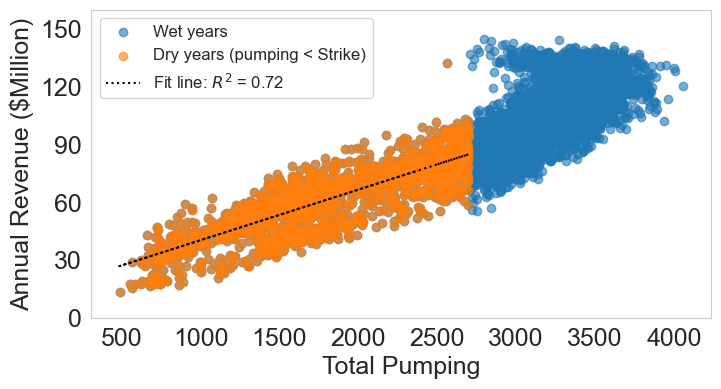

In [3]:
#######################basis risk for 2-year synthetic data#######################
###################### kern county water agency ##################################

fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_KCWA_3yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
revenue_3y['GroupNumber'] = None
counters = {}

for index, row in revenue_3y.iterrows():
    year = row['Year']
    simulation = row['Simulation']
    key = (year, simulation)
    if key not in counters:
        counters[key] = 1
    else:
        counters[key] += 1

    revenue_3y.at[index, 'GroupNumber'] = counters[key]

group_sorted = revenue_3y.sort_values(by=['Year', 'Simulation', 'GroupNumber'])

group_sorted_2yr = group_sorted[group_sorted['GroupNumber'] != 3]
y = group_sorted_2yr['Total Annual Revenue']
x = group_sorted_2yr['Total Pumping']

x_threshold = 2700

filtered_data = group_sorted_2yr[group_sorted_2yr['Total Pumping'] < x_threshold]
x_filtered = filtered_data['Total Pumping']
y_filtered = filtered_data['Total Annual Revenue']

ax.scatter(x, y, alpha=0.6, label='Wet years ')
ax.scatter(x_filtered, y_filtered, alpha=0.6, label='Dry years (pumping < Strike)')

slope_kcwa, intercept = np.polyfit(x_filtered, y_filtered, 1)
line = slope_kcwa * x_filtered + intercept  # Line equation for filtered data
corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]
r_squared = corr_coef ** 2
plt.plot(x_filtered, line, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared:.2f}')


corr_coef = np.corrcoef(x_filtered, y_filtered)[0, 1]

ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(False)
ax.legend(fontsize=12)
ax.set_ylim(0, 160)
plt.yticks(np.arange(0,160,30))

# ax.set_xlim(500, 4400)
# plt.savefig('plots/pumping_vs_revenue_KCWA_2yr.png')
plt.show()


Slope: 0.030365771542322544


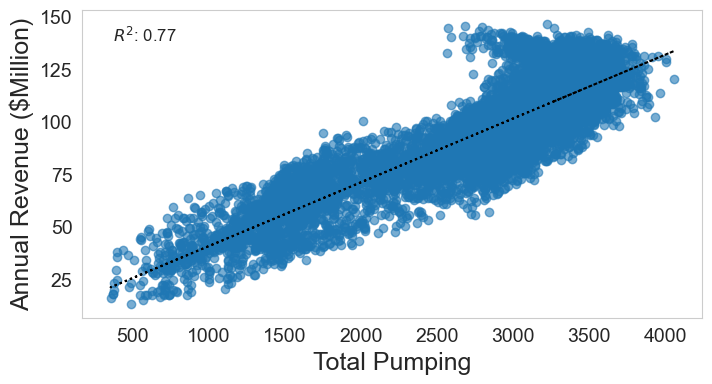

In [6]:
#######################basis risk for 3-year synthetic data#######################
###################### kern county water agency ##################################
fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_KCWA_3yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
y = read_file['Total Annual Revenue']
x = read_file['Total Pumping']
corr_coef = np.corrcoef(x, y)[0, 1]
r_squared = corr_coef ** 2
ax.scatter(x, y, alpha=0.6, label='All data')

slope_kcwa, intercept = np.polyfit(x, y, 1)
line = slope_kcwa * x + intercept  # This is the line equation
plt.plot(x, line, 'black', linestyle= ':', label=f'Fit line: y={slope_kcwa:.2f}x + {intercept:.2f}')
print("Slope:", slope_kcwa)

ax.annotate(f"$R^2$: {r_squared:.2f}", xy=(0.05, 0.90), xycoords='axes fraction',
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
# ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(False)
# ax.set_ylim(1, 14)
# ax.set_xlim(500, 4400)
# plt.savefig('plots/pumping_vs_revenue_KCWA_3yr.png')
plt.show()

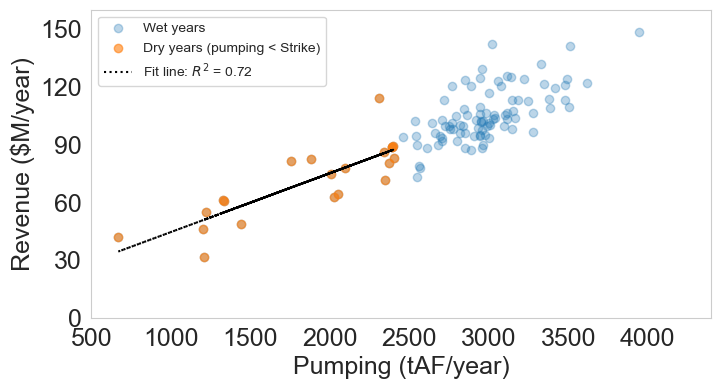

In [19]:
#######basis risk for Kern County Water Agency (110 data)###########################
###############################################################################

revenue_file = 'plots/pumping_vs_revenue_KCWA_110yr.csv'
Yearly_revenue = pd.read_csv(revenue_file)

x_threshold = 2704*0.9  # You can set this to the value you want

# Filter the data based on the threshold
filtered_data = Yearly_revenue[Yearly_revenue['Total Pumping'] < x_threshold]
x_filtered = filtered_data['Total Pumping']
y_filtered = filtered_data['Annual Revenue']

slope, intercept = np.polyfit(x_filtered, y_filtered, 1)
line_filtered = slope * x_filtered + intercept  # This is the line equation for filtered data
corr_coef_filtered = np.corrcoef(x_filtered, y_filtered)[0, 1]
r_squared_filtered = corr_coef_filtered ** 2

plt.figure(figsize=(8, 4))
plt.scatter(Yearly_revenue['Total Pumping'], Yearly_revenue['Annual Revenue'], alpha=0.3, label='Wet years')
plt.scatter(x_filtered, y_filtered, alpha=0.6, label='Dry years (pumping < Strike)')
plt.plot(x_filtered, line_filtered, 'black', linestyle=':', label=f'Fit line: $R^2$ = {r_squared:.2f}')

plt.xlabel("Pumping (tAF/year)", fontsize=18)
plt.ylabel("Revenue ($M/year)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(1, 160)
plt.xlim(500, 4400)
plt.yticks(np.arange(0, 160, 30))
plt.grid(False)
plt.legend()


# plt.annotate(f"$R^2$ (< Threshold): {r_squared_filtered:.2f}", xy=(0.05, 0.92), xycoords='axes fraction',
            #  fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))

# plt.savefig(f"plots/basis_risk_KCWA_110year.png")
plt.show()

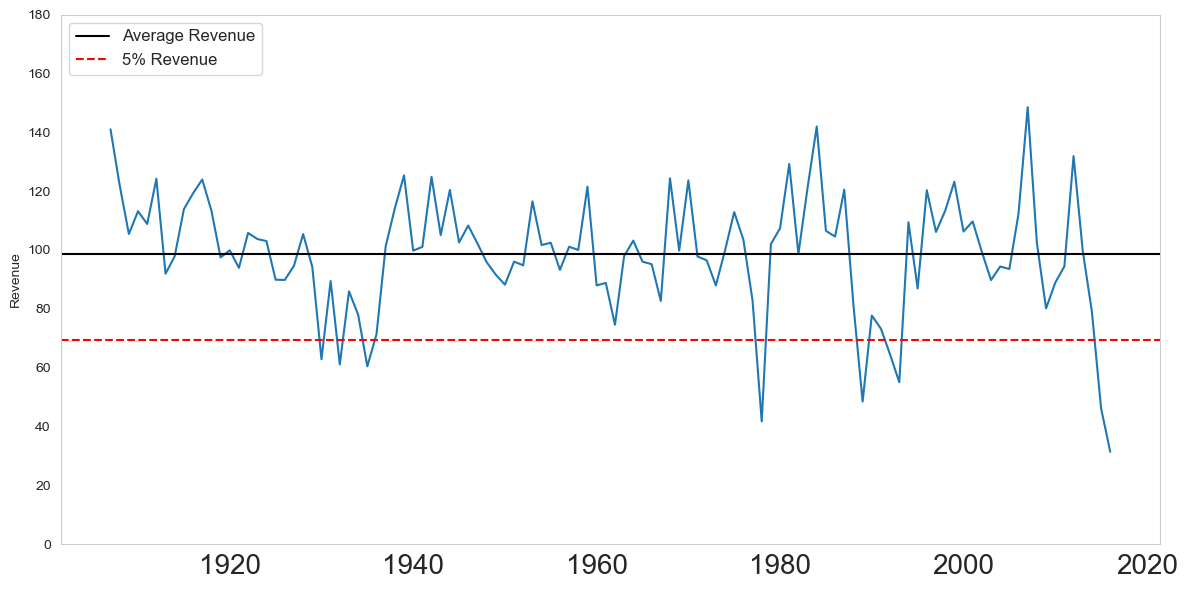

In [ ]:
Yearly_revenue['year'] = pd.date_range(start='1906', periods=110, freq='Y')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(Yearly_revenue['year'], Yearly_revenue['Annual Revenue'])
mean = Yearly_revenue['Annual Revenue'].mean()
lowpercentile = Yearly_revenue['Annual Revenue'].quantile(0.08)
plt.axhline(y=mean, color='black', linestyle='-', label='Average Revenue')
plt.axhline(y=lowpercentile, color='r', linestyle='--', label='5% Revenue')
# plt.title('Losthills Daily Revenue from 1906 to 2024')
# plt.xlabel('Year')
# plt.ylabel('Revenue')
plt
plt.ylim(0, 180)
plt.xticks(fontsize=20) 
plt.grid(True)
plt.legend(loc='upper left', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

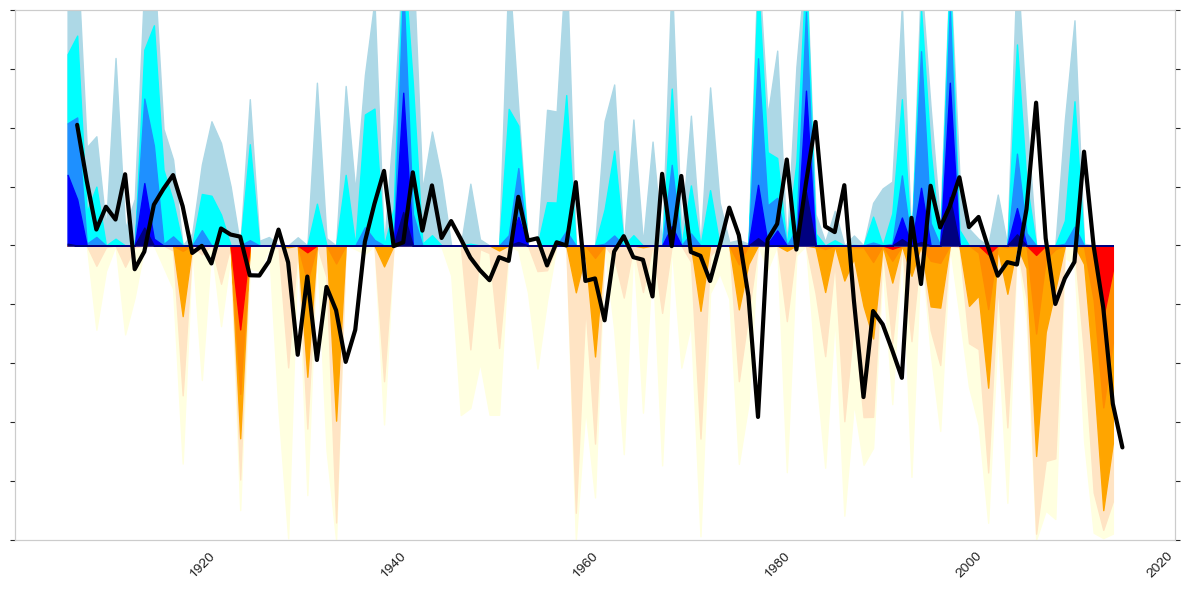

In [59]:
df = pd.read_csv('calfews_src/data/price_index/PALEO-California.csv')
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y')
df = df[(df['DATE'] >= '1906') & (df['DATE'] < '2016')]

# Assume Yearly_revenue is a DataFrame already loaded in your environment
Yearly_revenue['year'] = pd.date_range(start='1906', periods=len(Yearly_revenue), freq='Y')
# Yearly_revenue = Yearly_revenue[(Yearly_revenue['year'] >= '2000-01-01') & (Yearly_revenue['year'] < '2016-12-01')]

# Create the figure and the first subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot the drought severity time series
ax1.fill_between(df['DATE'], df['D0'], color='lightyellow', label='D0 - Abnormally Dry')
ax1.fill_between(df['DATE'], df['D1'], df['D2'], color='bisque', label='D1 - Moderate Drought')
ax1.fill_between(df['DATE'], df['D2'], df['D3'], color='orange', label='D2 - Severe Drought')
ax1.fill_between(df['DATE'], df['D3'], df['D4'], color='darkorange', label='D3 - Extreme Drought')
ax1.fill_between(df['DATE'], df['D4'], color='red', label='D4 - Exceptional Drought')
ax1.fill_between(df['DATE'], -df['W0'], color='lightblue', label='W0 - Abnormally Wet')
ax1.fill_between(df['DATE'], -df['W1'], -df['W2'], color='cyan', label='W1 - Moderate Wetness')
ax1.fill_between(df['DATE'], -df['W2'], -df['W3'], color='dodgerblue', label='W2 - Significant Wetness')
ax1.fill_between(df['DATE'], -df['W3'], -df['W4'], color='blue', label='W3 - Very Wet')
ax1.fill_between(df['DATE'], -df['W4'], color='navy', label='W4 - Extremely Wet')

# ax1.set_ylabel('Percentage of Area in Drought (%)', fontsize=16)
# ax1.set_title('Drought Severity and Index Price Time Series for CA (1906-2015)')
# ax1.yaxis.set_tick_params(labelsize=16)
# ax1.xaxis.set_tick_params(labelsize=16)
# ax1.legend(loc='lower left', fontsize=14)
ax1.set_yticklabels([])
plt.xticks(rotation=45)
ax1.set_ylim(-80, 100)
ax1.invert_yaxis() 
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(Yearly_revenue['year'], Yearly_revenue['Annual Revenue'], color='black', linewidth=3,label='Annual Revenue')
mean = Yearly_revenue['Annual Revenue'].mean()
lowpercentile = Yearly_revenue['Annual Revenue'].quantile(0.08)
# ax2.axhline(y=mean, color='black', linestyle='-', label='Average Revenue')
# ax2.axhline(y=lowpercentile, color='r', linestyle='--', label='5% Revenue')

# ax2.set_ylabel('Revenue', fontsize=16)
# ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_ylim(0, 180)
# ax2.legend(loc='upper right', fontsize=12
ax2.set_yticklabels([])
ax2.grid(False)

plt.tight_layout()
plt.savefig('plots/drought_severity_and_revenue.png', dpi=300, transparent =True)
plt.show()

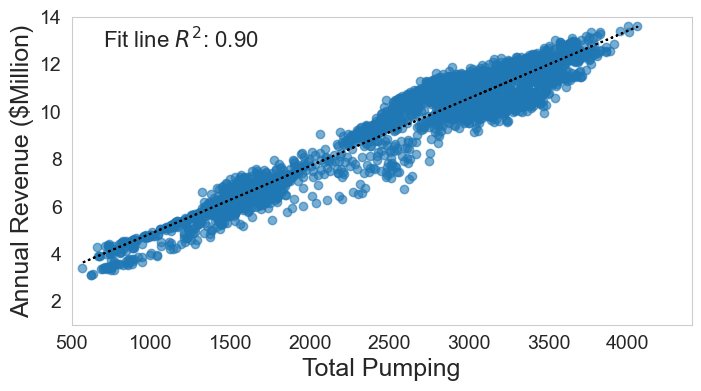

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))
read_file = 'plots/pumping_vs_revenue_losthills_1yr.csv'
read_file= pd.read_csv(read_file, index_col=0, parse_dates=True)
y = read_file['Annual Revenue']
x = read_file['Total Pumping']
corr_coef = np.corrcoef(x, y)[0, 1]
r_squared = corr_coef ** 2
ax.scatter(x, y, alpha=0.6, label='All data')

slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation
plt.plot(x, line, 'black', linestyle= ':', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')

ax.annotate(f"Fit line $R^2$: {r_squared:.2f}", xy=(0.05, 0.90), xycoords='axes fraction',
                    fontsize=16, bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white'))
# ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
ax.set_xlabel("Total Pumping",  fontsize=18)
ax.set_ylabel("Annual Revenue ($Million)",  fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(False)
ax.set_ylim(1, 14)
ax.set_xlim(500, 4400)
plt.show()

# Intial condition and net payout 

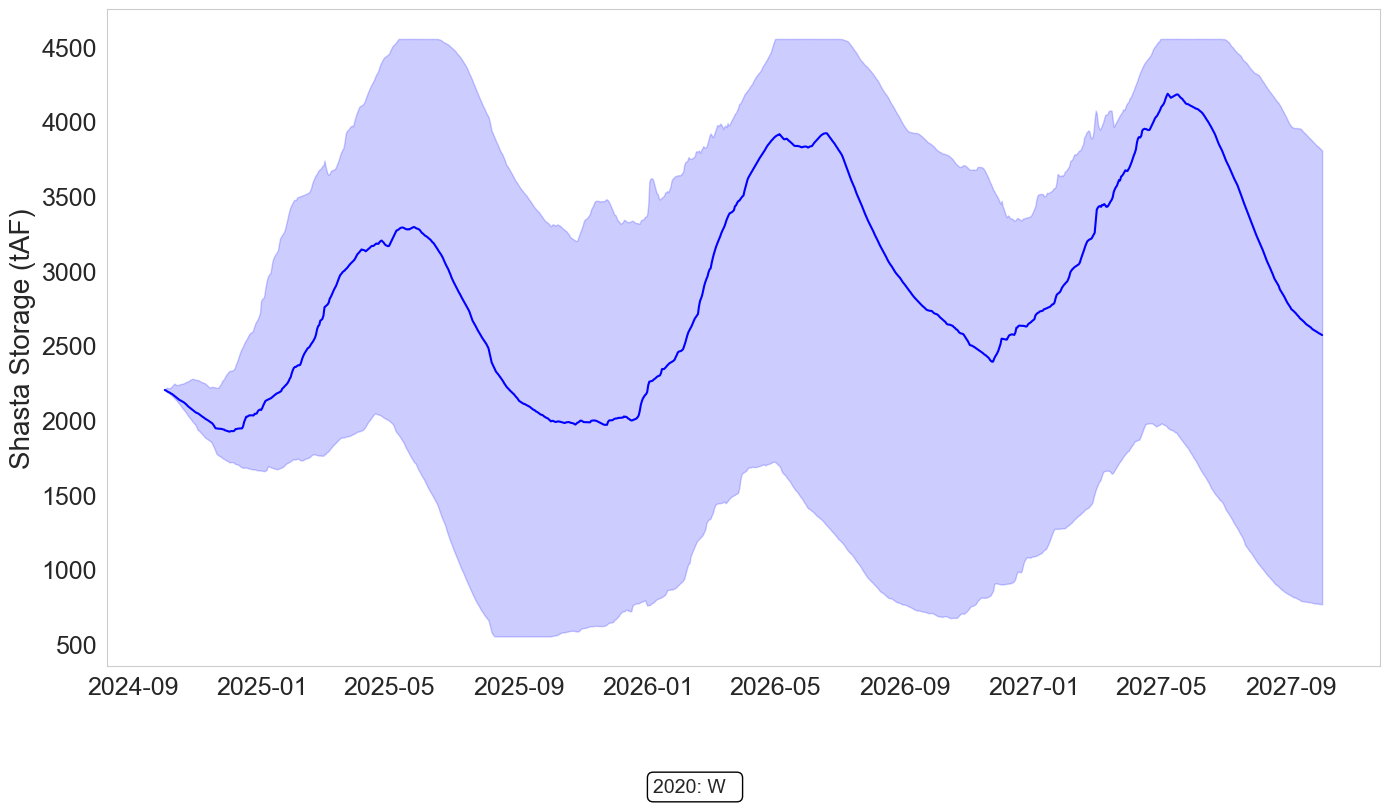

In [10]:
base_output_folder = "results/startyear_4_1"
start_year = 2020
end_year = 2020

yearly_medians = {}
yearly_25 = {}
yearly_75 = {}

for year in range(start_year, end_year + 1):
    all_simulations = []
    
    for i in range(1, 101): 
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        all_simulations.append(data['shasta_S'])
    
    sim_df = pd.concat(all_simulations, axis=1)
    yearly_medians[year] = sim_df.median(axis=1)
    yearly_25[year] = sim_df.quantile(0.10, axis=1)
    yearly_75[year] = sim_df.quantile(0.95, axis=1)

median_df = pd.DataFrame(yearly_medians)
p25_df = pd.DataFrame(yearly_25)
p75_df = pd.DataFrame(yearly_75)

plt.figure(figsize=(14, 8))

water_year_types = "W W W AN AN D D BN D W W C C BN AN W D C C C D W BN W D C C W W"
year_types = water_year_types.split()

color_map = {
    'W': 'blue',       # Wet
    'AN': 'royalblue', # Above Normal
    'BN': 'yellow',    # Below Normal
    'D': 'orange',     # Dry
    'C': 'red'         # Critical
}
type_names = {
    'W': 'Wet',
    'AN': 'Above Normal',
    'BN': 'Below Normal',
    'D': 'Dry',
    'C': 'Critical'
}
legend_handles = {}

for i, year in enumerate(range(start_year, end_year + 1)):
    if year in median_df.columns:
        year_type = year_types[i]
        color = color_map[year_type]
        
        line = plt.plot(median_df[year], 
                 color='blue', 
                 label=f'{year} ({year_type})')

        plt.fill_between(median_df.index, p25_df[year], p75_df[year], color='blue', alpha=0.2)
        
        if year_type not in legend_handles:
            legend_handles[year_type] = line[0]

# plt.title('Median Shasta Storage Across 100 Simulations (1996-2024)')
plt.ylabel('Shasta Storage (tAF)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)

# first_legend = plt.legend(handles=list(legend_handles.values()), 
#                          labels=[f"{k} - {type_names[k]}" for k in legend_handles.keys()],
#                          loc='lower right', fontsize=14)
# plt.gca().add_artist(first_legend)

years_text = ""
for i, year in enumerate(range(start_year, end_year + 1)):
    years_text += f"{year}: {year_types[i]}  "
    if (i+1) % 5 == 0:
        years_text += "\n"

plt.figtext(0.5, -0.03, years_text, ha='center', fontsize=14, va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f'plots/shasta_storage_{year}.png', transparent=True) #, transparent=True
plt.show()

In [34]:
base_output_folder = "results/startyear_4_1"
start_year = 1996
end_year = 2024

yearly_medians = {}

for year in range(start_year, end_year + 1):
    all_simulations = []
    
    for i in range(1, 101): 
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        all_simulations.append(data['shasta_S'])
        # all_simulations.append(data['delta_HRO_pump'].resample('AS-OCT').sum())

    sim_df = pd.concat(all_simulations, axis=1)
    yearly_medians[year] = sim_df.median(axis=1)
median_df = pd.DataFrame(yearly_medians)


ValueError: Shape of passed values is (1095, 1926), indices imply (1095, 100)

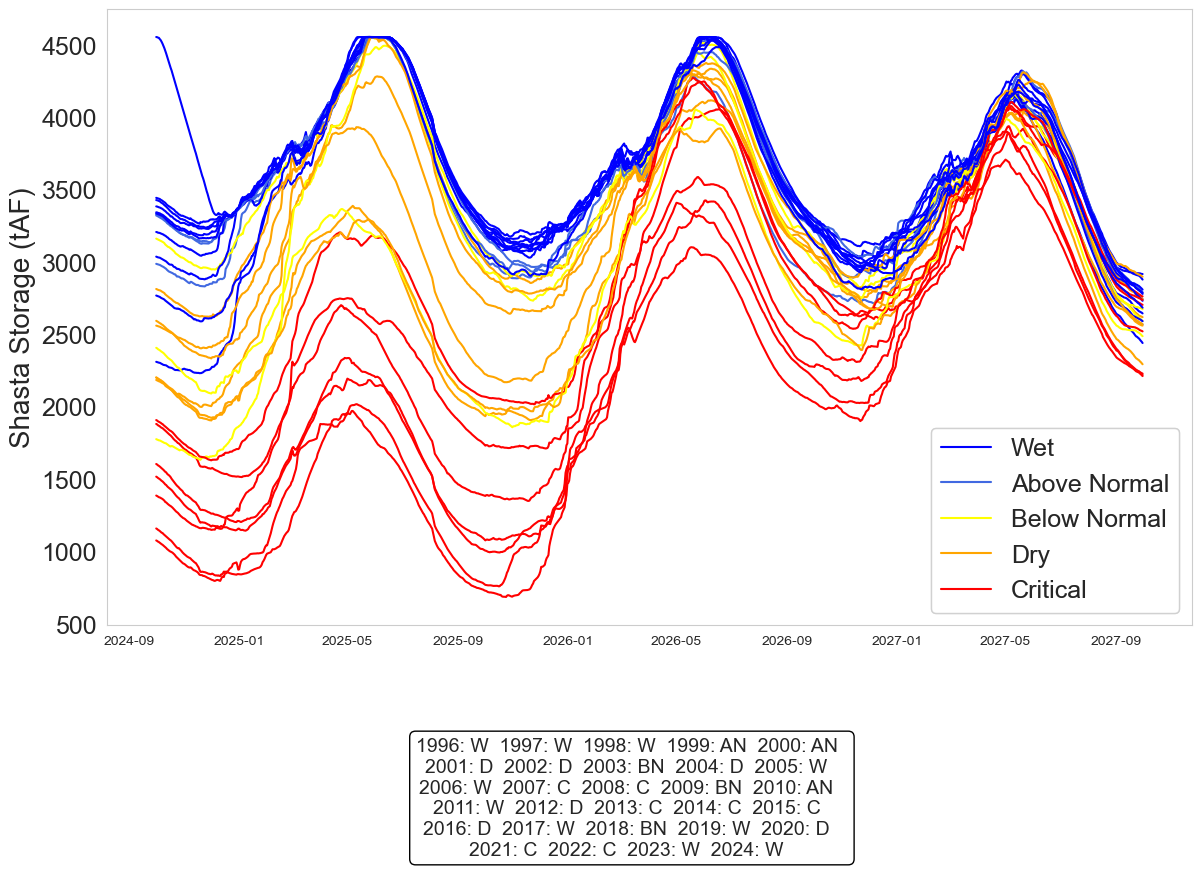

In [ ]:
plt.figure(figsize=(14, 8))

water_year_types = "W W W AN AN D D BN D W W C C BN AN W D C C C D W BN W D C C W W"
year_types = water_year_types.split()

color_map = {
    'W': 'blue',       # Wet
    'AN': 'royalblue', # Above Normal
    'BN': 'yellow',      # Below Normal
    'D': 'orange',     # Dry
    'C': 'red'         # Critical
}
type_names = {
    'W': 'Wet',
    'AN': 'Above Normal',
    'BN': 'Below Normal',
    'D': 'Dry',
    'C': 'Critical'
}
legend_handles = {}

for i, year in enumerate(range(start_year, end_year + 1)):
    if year in median_df.columns:
        year_type = year_types[i]
        color = color_map[year_type]
        
        line = plt.plot(median_df[year], 
                 color=color, 
                 label=f'{year} ({year_type})')
        
        if year_type not in legend_handles:
            legend_handles[year_type] = line[0]

# plt.title('Median Shasta Storage Across 100 Simulations (1996-2024)')
plt.ylabel('Shasta Storage (tAF)', fontsize = 20)
# plt.xticks(fontsize = 14)
plt.yticks(fontsize = 18)


plt.grid(False)
order = ['W', 'AN', 'BN', 'D', 'C'] 
sorted_handles = sorted(legend_handles.items(), key=lambda x: order.index(x[0]))

first_legend = plt.legend(handles=[item[1] for item in sorted_handles], 
                          labels=[f"{type_names[k]}" for k, _ in sorted_handles],
                          loc='lower right', fontsize=18)
plt.gca().add_artist(first_legend)

# Add a separate text annotation for the year mapping
years_text = ""
for i, year in enumerate(range(start_year, end_year + 1)):
    years_text += f"{year}: {year_types[i]}  "
    if (i+1) % 5 == 0:  # Line break every 5 years
        years_text += "\n"

plt.figtext(0.5, -0.03, years_text, ha='center', fontsize = 14, va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

# plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the text at the bottom
plt.savefig(f'plots/shasta_storage_ensemble.png') #, transparent=True
plt.show()


In [35]:
import numpy as np
from scipy.stats import norm
import scipy.stats as st


def simple_wang_transform(payouts, lam= -0.25):
    """
    Apply a simplified Wang transform to an input tuple of payouts and return both
    the transformed payout (premium) and the net position (whole).

    :param payouts: A tuple of payout values.
    :param lam: Lambda parameter for the Wang transform (risk adjustment).
    :param from_user: Boolean flag for determining perspective (user's or insurer's).
    :return: A tuple containing the transformed payout (premium) and the whole.
    """
    payouts = pd.DataFrame(payouts, columns=['payout'])
    unique_pays = pd.DataFrame()
    unique_pays['unique'] = payouts.payout.unique()
    unique_pays['prob'] = 0 
    for j in range(len(unique_pays)):  
        count = 0
        val = unique_pays['unique'].iloc[j]
        for i in np.arange(len(payouts)): 
            if payouts['payout'].iloc[i] == val: 
                count += 1
        unique_pays['prob'].iloc[j] = count/len(payouts)
    unique_pays.sort_values(inplace=True, by='unique')
    dum = unique_pays['prob'].cumsum()  # asset cdf
    dum = st.norm.cdf(st.norm.ppf(dum) - 0.25)  # risk transformed payout cdf
    dum = np.append(dum[0], np.diff(dum))  # risk transformed asset pdf
    prem = (dum * unique_pays['unique']).sum()


    whole = payouts - prem

    return prem


In [36]:
base_output_folder = "results/startyear_4_1"
start_year = 1996
end_year = 2024
all_first_years_data = []
all_second_years_data = []
all_third_years_data = []

for year in range(start_year, end_year + 1):
    for i in range(1, 101):
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        delta_HRO_pump_resampled = data['delta_HRO_pump'].resample('AS-OCT').sum()
        
        first_year_value = delta_HRO_pump_resampled.iloc[0]
        second_year_value = delta_HRO_pump_resampled.iloc[1]
        third_year_value = delta_HRO_pump_resampled.iloc[2]
        all_first_years_data.append(first_year_value)
        all_second_years_data.append(second_year_value)
        all_third_years_data.append(third_year_value)

mean_value = np.mean(all_first_years_data + all_second_years_data + all_third_years_data)
print("Mean value of all years:", mean_value)

Mean value of all years: 2704.2651525018823


In [37]:
base_output_folder = "results/startyear_4_1"
start_year = 1996
end_year = 2024
slope = slope_kcwa
mean_value = 2704  ##?
strike_90 = 0.9 * mean_value
strike_80 = 0.8 * mean_value
strike_70 = 0.7 * mean_value

expectation_of_payouts = []
expectation_of_payouts_2y = []
expectation_of_payouts_3y = []
premium_1yr = []
premium_2yr = []
premium_3yr = []

for year in range(start_year, end_year + 1):
    all_first_years_data = []
    all_second_years_data = []
    all_third_years_data = []

    for i in range(1, 101):
        trace_file = os.path.join(base_output_folder, f"{year}_{i}", 'results.hdf5')
        data = get_results_sensitivity_number_outside_model(trace_file, '')
        delta_HRO_pump_resampled = data['delta_HRO_pump'].resample('AS-OCT').sum()
        
        first_year_value = delta_HRO_pump_resampled.iloc[0]
        second_year_value = delta_HRO_pump_resampled.iloc[1]
        third_year_value = delta_HRO_pump_resampled.iloc[2]
        all_first_years_data.append(first_year_value)
        all_second_years_data.append(second_year_value)
        all_third_years_data.append(third_year_value)

    payouts_90_1yr = [slope * max((strike_90 - f), 0) for f in all_first_years_data]
    # print(f"payouts_90_1yr: {payouts_90_1yr}")
    payouts_80_1yr = [slope * max((strike_80 - f), 0) for f in all_first_years_data]
    payouts_70_1yr = [slope * max((strike_70 - f), 0) for f in all_first_years_data]
    payouts_90_2yr = [slope * max((strike_90 - f), 0) for f in all_second_years_data]
    payouts_80_2yr = [slope * max((strike_80 - f), 0) for f in all_second_years_data]
    payouts_70_2yr = [slope * max((strike_70 - f), 0) for f in all_second_years_data]
    payouts_90_3yr = [slope * max((strike_90 - f), 0) for f in all_third_years_data]
    payouts_80_3yr = [slope * max((strike_80 - f), 0) for f in all_third_years_data]
    payouts_70_3yr = [slope * max((strike_70 - f), 0) for f in all_third_years_data]

    payouts_90_2yr_combined = [a + b for a, b in zip(payouts_90_2yr, payouts_90_1yr)]
    payouts_80_2yr_combined = [a + b for a, b in zip(payouts_80_2yr, payouts_80_1yr)]
    payouts_70_2yr_combined = [a + b for a, b in zip(payouts_70_2yr, payouts_70_1yr)]
    payouts_90_3yr_combined = [a + b + c for a, b, c in zip(payouts_90_3yr, payouts_90_2yr, payouts_90_1yr)]
    payouts_80_3yr_combined = [a + b + c for a, b, c in zip(payouts_80_3yr, payouts_80_2yr, payouts_80_1yr)]
    payouts_70_3yr_combined = [a + b + c for a, b, c in zip(payouts_70_3yr, payouts_70_2yr, payouts_70_1yr)]

    premium_90_1yr = simple_wang_transform(payouts_90_1yr)
    premium_80_1yr = simple_wang_transform(payouts_80_1yr)
    premium_70_1yr = simple_wang_transform(payouts_70_1yr)
    premium_90_2yr = simple_wang_transform(payouts_90_2yr_combined)
    premium_80_2yr = simple_wang_transform(payouts_80_2yr_combined)
    premium_70_2yr = simple_wang_transform(payouts_70_2yr_combined)
    premium_90_3yr = simple_wang_transform(payouts_90_3yr_combined)
    premium_80_3yr = simple_wang_transform(payouts_80_3yr_combined)
    premium_70_3yr = simple_wang_transform(payouts_70_3yr_combined)

    expectation_payout_90_1yr = np.mean(payouts_90_1yr)
    expectation_payout_80_1yr = np.mean(payouts_80_1yr)
    expectation_payout_70_1yr = np.mean(payouts_70_1yr)
    expectation_payout_90_2yr = np.mean(payouts_90_2yr_combined)
    expectation_payout_80_2yr = np.mean(payouts_80_2yr_combined)
    expectation_payout_70_2yr = np.mean(payouts_70_2yr_combined)
    expectation_payout_90_3yr = np.mean(payouts_90_3yr_combined)
    expectation_payout_80_3yr = np.mean(payouts_80_3yr_combined)
    expectation_payout_70_3yr = np.mean(payouts_70_3yr_combined)

    expectation_of_payouts.append((expectation_payout_90_1yr, expectation_payout_80_1yr, expectation_payout_70_1yr))
    expectation_of_payouts_2y.append((expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr))
    expectation_of_payouts_3y.append((expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr))

    premium_1yr.append((premium_90_1yr, premium_80_1yr, premium_70_1yr))
    premium_2yr.append((premium_90_2yr, premium_80_2yr, premium_70_2yr))
    premium_3yr.append((premium_90_3yr, premium_80_3yr, premium_70_3yr))


# Convert to arrays for easy plotting
expectation_payout_90s, expectation_payout_80s, expectation_payout_70s = zip(*expectation_of_payouts)
expectation_payout_90_2yr, expectation_payout_80_2yr, expectation_payout_70_2yr = zip(*expectation_of_payouts_2y)
expectation_payout_90_3yr, expectation_payout_80_3yr, expectation_payout_70_3yr = zip(*expectation_of_payouts_3y)

premium_90_1yr, premium_80_1yr, premium_70_1yr = zip(*premium_1yr)
premium_90_2yr, premium_80_2yr, premium_70_2yr = zip(*premium_2yr)
premium_90_3yr, premium_80_3yr, premium_70_3yr = zip(*premium_3yr)

c:\Users\danli\.conda\envs\.venv_conda_calfews\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


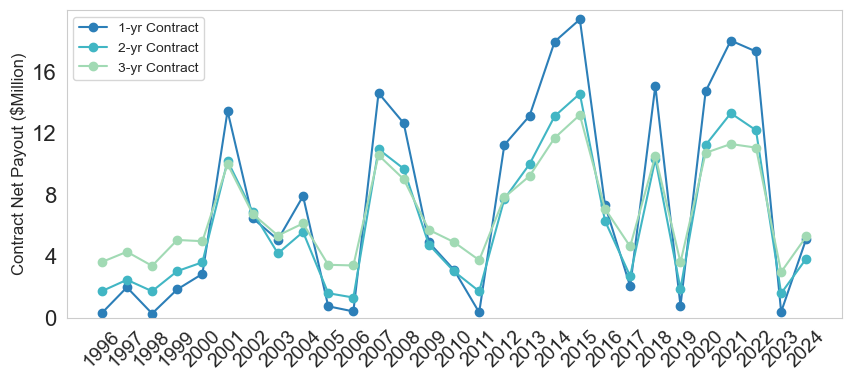

In [43]:
plt.figure(figsize=(10, 4))
years = np.arange(start_year, end_year + 1)
x_indices = np.arange(len(years))

plt.plot(years, expectation_payout_90s, label='1-yr Contract', marker='o', color='#2c7fb8')
plt.plot(years, np.array(expectation_payout_90_2yr)/2, label='2-yr Contract', marker='o', color='#41b6c4')
plt.plot(years, np.array(expectation_payout_90_3yr)/3, label='3-yr Contract', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Contract Net Payout ($Million)', fontsize=12)
plt.xticks(years, fontsize=14, rotation=45)
plt.yticks(fontsize=16)
plt.yticks(np.arange(0,20,4))
plt.ylim(0,20)
plt.legend(fontsize=10)
plt.grid(False)
plt.savefig('plots/expectation_payouts.png', dpi=300, bbox_inches='tight')
plt.show()

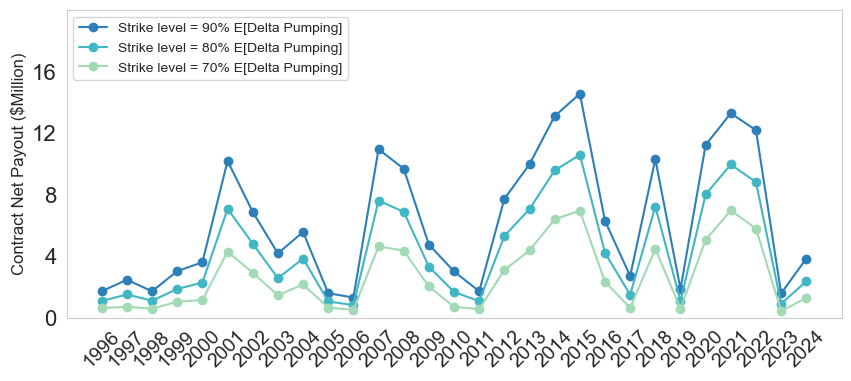

In [47]:
plt.figure(figsize=(10, 4))
years = np.arange(start_year, end_year + 1)
x_indices = np.arange(len(years))

plt.plot(years, np.array(expectation_payout_90_2yr)/2, label='Strike level = 90% E[Delta Pumping]', marker='o', color='#2c7fb8')
plt.plot(years, np.array(expectation_payout_80_2yr)/2, label='Strike level = 80% E[Delta Pumping]', marker='o', color='#41b6c4')
plt.plot(years, np.array(expectation_payout_70_2yr)/2, label='Strike level = 70% E[Delta Pumping]', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Contract Net Payout ($Million)', fontsize=12)
plt.xticks(years, fontsize=14, rotation=45)
plt.yticks(fontsize=16)
plt.yticks(np.arange(0,20,4))
plt.ylim(0,20)
plt.legend(fontsize=10, loc='upper left')
plt.grid(False)
plt.savefig('plots/expectation_payouts_strike.png', dpi=300, bbox_inches='tight')
plt.show()

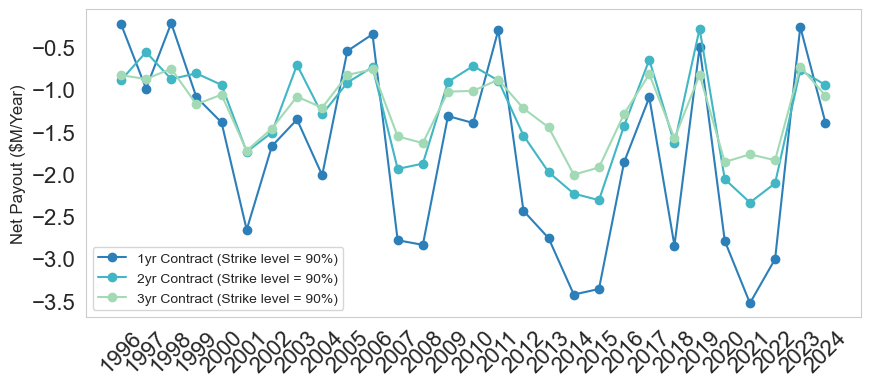

In [96]:
plt.figure(figsize=(10, 4))

plt.plot(years, tuple(np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Payout ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

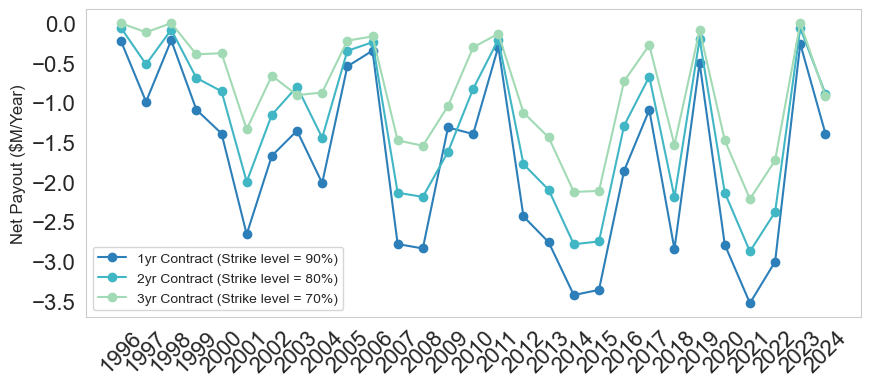

In [97]:
plt.figure(figsize=(10, 4))

plt.plot(years, tuple(np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(expectation_payout_80s) - np.array(premium_80_1yr)), label='2yr Contract (Strike level = 80%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='3yr Contract (Strike level = 70%)', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Payout ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

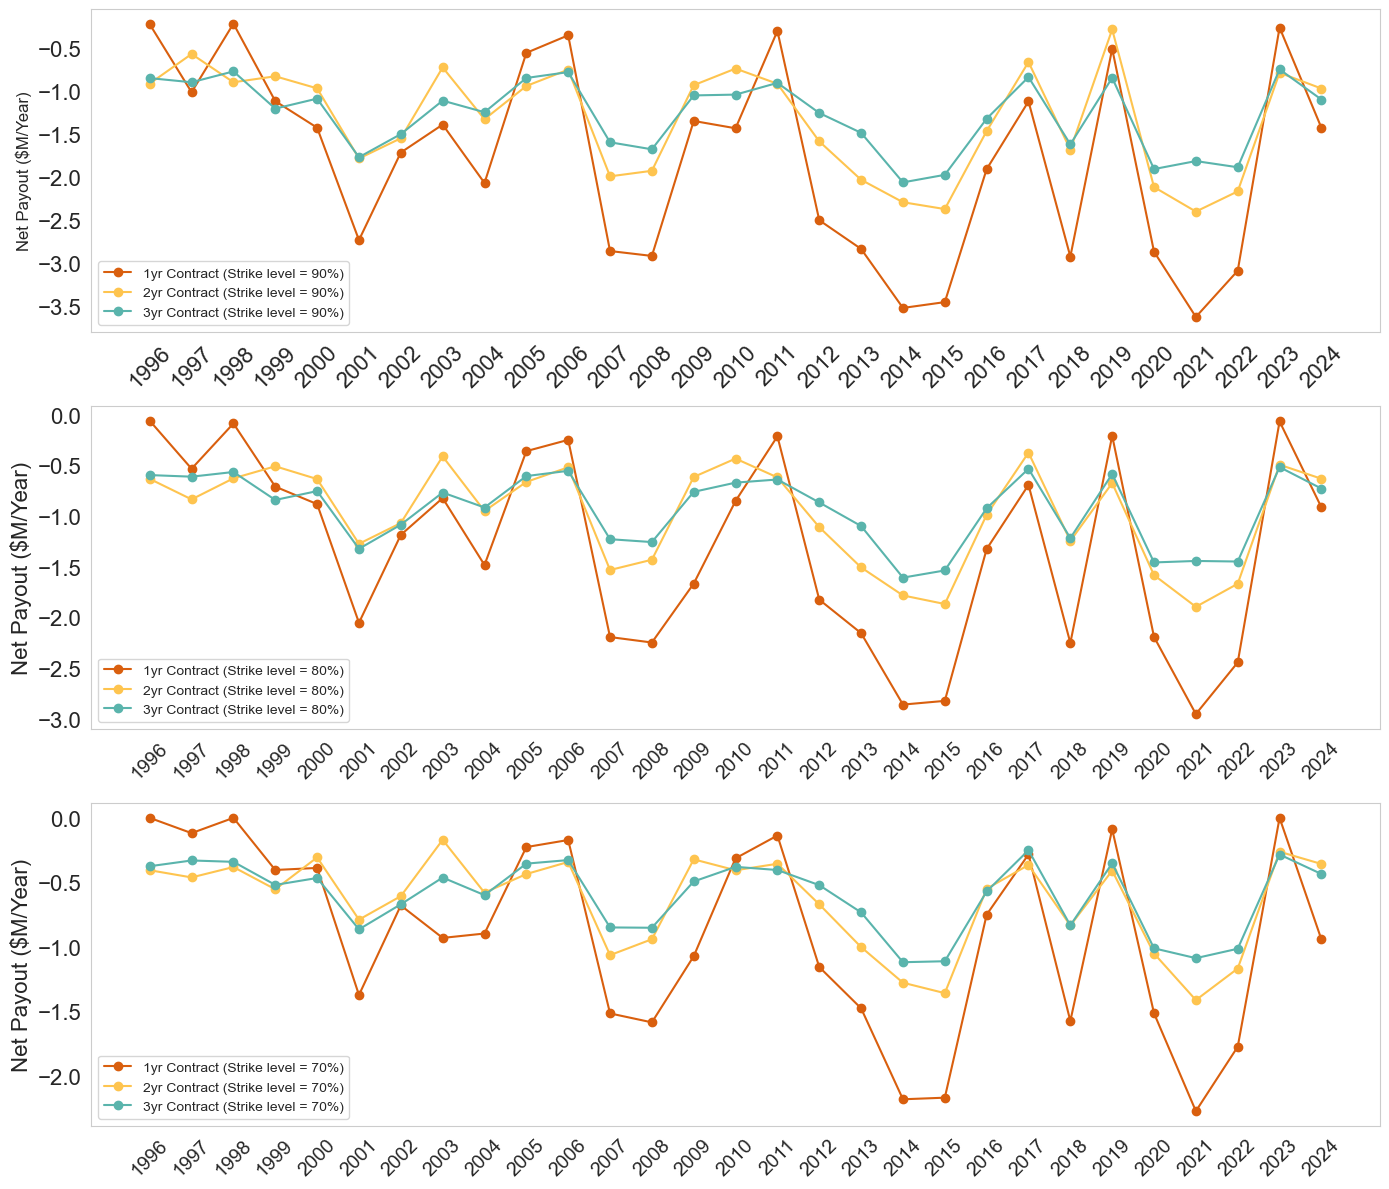

In [48]:
plt.figure(figsize=(14, 12))
years = np.arange(start_year, end_year + 1)
x_indices = np.arange(len(years))
plt.subplot(311)
plt.plot(years, tuple(np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#d95f0e')
plt.plot(years, tuple(np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#fec44f')
plt.plot(years, tuple(np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#5ab4ac')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Payout ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

plt.subplot(312)
plt.plot(years, tuple(np.array(expectation_payout_80s) - np.array(premium_80_1yr)), label='1yr Contract (Strike level = 80%)', marker='o', color='#d95f0e')
plt.plot(years, tuple(np.array(expectation_payout_80_2yr)/2 - np.array(premium_80_2yr)/2), label='2yr Contract (Strike level = 80%)', marker='o', color='#fec44f')
plt.plot(years, tuple(np.array(expectation_payout_80_3yr)/3 - np.array(premium_80_3yr)/3), label='3yr Contract (Strike level = 80%)', marker='o', color='#5ab4ac')
# plt.plot(years, expectation_payout_80s, label='1yr Contract (Strike level = 80%)', marker='o', color= '#d95f0e')
# plt.plot(years, np.array(expectation_payout_80_2yr)/2, label='2yr Contract (Strike level = 80%)', marker='o', color='#fec44f')
# plt.plot(years, np.array(expectation_payout_80_3yr)/3, label='3yr Contract (Strike level = 80%)', marker='o', color= '#5ab4ac')
# plt.plot(years, premium_80_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_80_1yr')
# plt.plot(years, np.array(premium_80_2yr)/2, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_80_2yr')
# plt.plot(years, np.array(premium_80_3yr)/3, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_80_3yr')
plt.ylabel('Net Payout ($M/Year)', fontsize=16)
# plt.title('Expectation of Payouts per Contract Period', fontsize=18)
plt.xticks(years, fontsize=14, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

plt.subplot(313)
plt.plot(years, tuple(np.array(expectation_payout_70s) - np.array(premium_70_1yr)), label='1yr Contract (Strike level = 70%)', marker='o', color='#d95f0e')
plt.plot(years, tuple(np.array(expectation_payout_70_2yr)/2 - np.array(premium_70_2yr)/2), label='2yr Contract (Strike level = 70%)', marker='o', color='#fec44f')
plt.plot(years, tuple(np.array(expectation_payout_70_3yr)/3 - np.array(premium_70_3yr)/3), label='3yr Contract (Strike level = 70%)', marker='o', color='#5ab4ac')
# plt.plot(years, expectation_payout_70s, label='1yr Contract (Strike level = 70%)', marker='o', color='#d95f0e')
# plt.plot(years, np.array(expectation_payout_70_2yr)/2, label='2yr Contract (Strike level = 70%)', marker='o', color='#fec44f')
# plt.plot(years, np.array(expectation_payout_70_3yr)/3, label='3yr Contract (Strike level = 70%)', marker='o', color='#5ab4ac')
# plt.plot(years, premium_70_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_70_1yr')
# plt.plot(years, np.array(premium_70_2yr)/2, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_70_2yr')
# plt.plot(years, np.array(premium_70_3yr)/3, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_70_3yr')
plt.ylabel('Net Payout ($M/Year)', fontsize=16)
# plt.title('Expectation of Payouts per Contract Period', fontsize=18)
plt.xticks(years, fontsize=14, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()

plt.show()

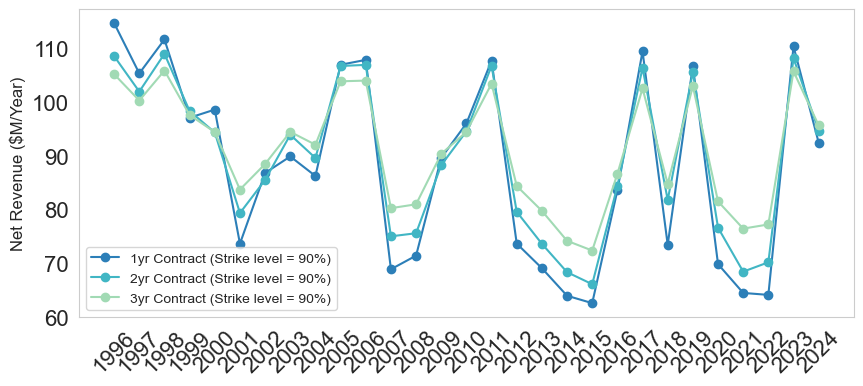

In [102]:
plt.figure(figsize=(10, 4))
start_year = 1996
end_year = 2024
years = np.arange(start_year, end_year + 1)


plt.plot(years, tuple(np.array(filtered_1y['Total Annual Revenue']) + np.array(expectation_payout_90s) - np.array(premium_90_1yr)), label='1yr Contract (Strike level = 90%)', marker='o', color='#2c7fb8')
plt.plot(years, tuple(np.array(filtered_2y['Total Annual Revenue']) + np.array(expectation_payout_90_2yr)/2 - np.array(premium_90_2yr)/2), label='2yr Contract (Strike level = 90%)', marker='o', color='#41b6c4')
plt.plot(years, tuple(np.array(filtered_3y['Total Annual Revenue']) + np.array(expectation_payout_90_3yr)/3 - np.array(premium_90_3yr)/3), label='3yr Contract (Strike level = 90%)', marker='o', color='#a1dab4')
# plt.plot(years, premium_90_1yr, color='red', linestyle='--', linewidth=1, label='Mark Year: premium_90_1yr')
# plt.plot(years, premium_90_2yr, color='orange', linestyle='--', linewidth=1, label='Mark Year: premium_90_2yr')
# plt.plot(years, premium_90_3yr, color='darkgreen', linestyle='--', linewidth=1, label='Mark Year: premium_90_3yr')
plt.ylabel('Net Revenue ($M/Year)', fontsize=12)
plt.xticks(years, fontsize=16, rotation=45)
plt.yticks(fontsize=16)
# plt.ylim(-0.35, 0.05)
plt.legend(fontsize=10)
plt.grid(False)

In [103]:
def calculate_payout(total_pumping, slope, strike_80):
    return slope * max(strike_80 - total_pumping, 0)

# Apply the function to each row in group_sorted['Total Pumping']
group_sorted['payout'] = group_sorted['Total Pumping'].apply(lambda x: calculate_payout(x, slope, strike_80))
year_premium_map = {year: premium for year, premium in zip(range(1996, 2025), np.array(premium_80_2yr)/2)}

group_sorted['premium'] = group_sorted['Year'].map(year_premium_map)
group_sorted['net_rev'] = group_sorted['Total Annual Revenue'] + group_sorted['payout']- group_sorted['premium']

Mean Annual Revenue: 92.41288241992275
5th Percentile Annual Revenue: 44.75766392453089


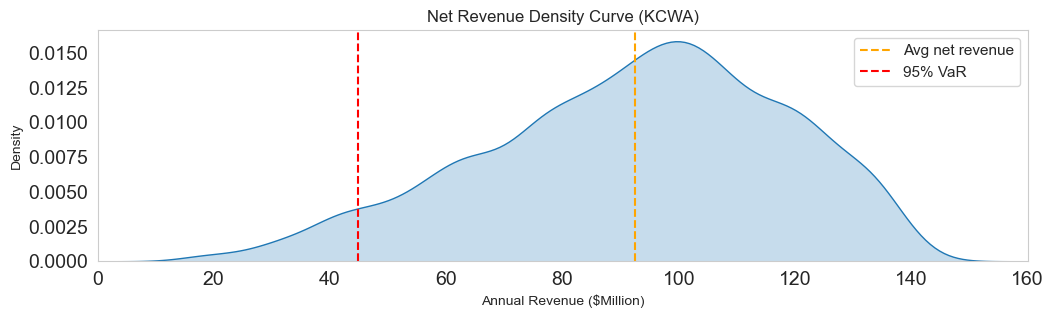

In [111]:
plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['Total Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['Total Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(group_sorted['Total Annual Revenue'])}")
first_percentile = np.percentile(group_sorted['Total Annual Revenue'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='95% VaR')

# plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0, 160)

plt.legend(fontsize=11, loc ='upper right')
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_noContract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 91.87410064398654
5th Percentile Annual Revenue: 59.283064961577686


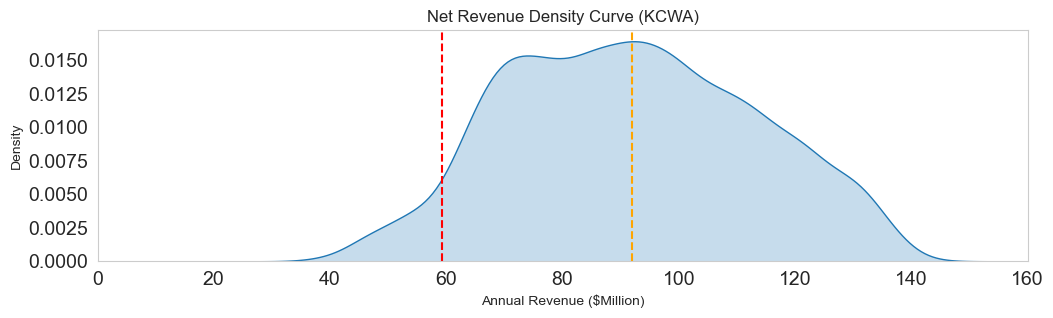

In [110]:

plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve (KCWA)")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile_net = np.percentile(group_sorted['net_rev'], 5)
print(f"5th Percentile Annual Revenue: {first_percentile_net}")
plt.axvline(x = first_percentile_net, color='red', linestyle='--', label='95% VaR')
plt.ylabel("Density")
plt.xlim(0, 160)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 8.839274038301143
5th Percentile Annual Revenue: 2.4033134156665694


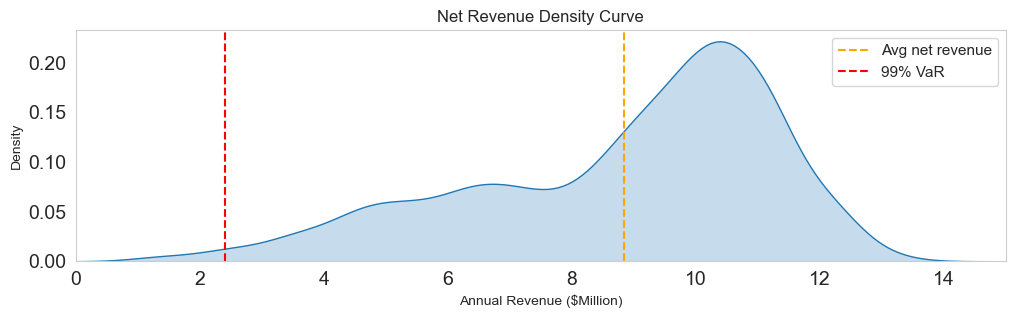

In [17]:
plt.figure(figsize=(12, 3))
sns.kdeplot(group_sorted['Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(group_sorted['Annual Revenue'])}")
first_percentile = np.percentile(group_sorted['Annual Revenue'], 1)
print(f"5th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='99% VaR')

plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc ='upper right')
plt.grid(False)
# plt.savefig('plots/net_revenue_density_curve_noContract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 8.753966823215864
1th Percentile Annual Revenue: 3.742054555119918


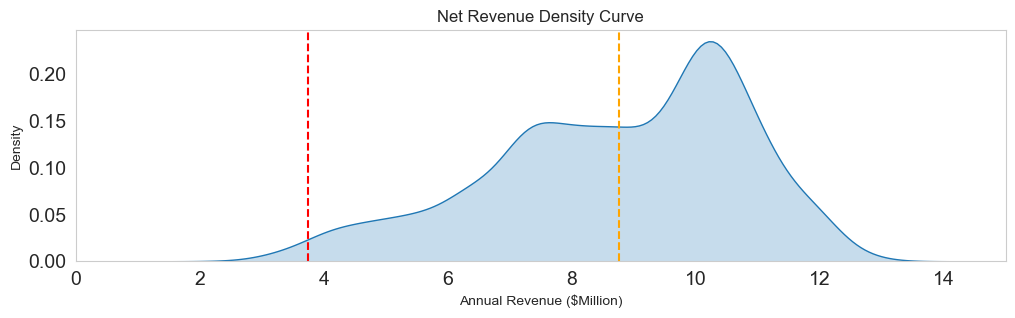

In [76]:


plt.figure(figsize=(12, 3))

sns.kdeplot(group_sorted['net_rev'], fill=True)
plt.title("Net Revenue Density Curve")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x = np.mean(group_sorted['net_rev']), color='orange', linestyle='--', label='Mean')
print(f"Mean Annual Revenue: {np.mean(group_sorted['net_rev'])}")

first_percentile = np.percentile(group_sorted['net_rev'], 1)
print(f"1th Percentile Annual Revenue: {first_percentile}")
plt.axvline(x = first_percentile, color='red', linestyle='--', label='99% VaR')
plt.ylabel("Density")
plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2yrcontract.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 7.088408770214207
1st Percentile Annual Revenue: 1.2377327493041919


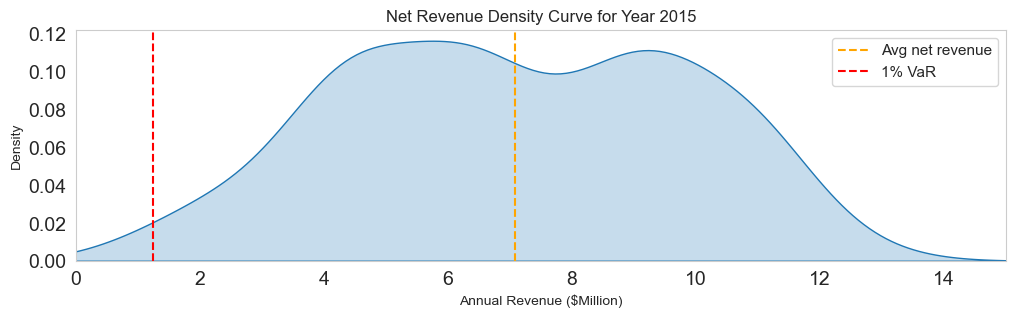

In [19]:
filtered_data = group_sorted[group_sorted['Year'] == 2015]

plt.figure(figsize=(12, 3))
sns.kdeplot(filtered_data['Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve for Year 2015")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x=np.mean(filtered_data['Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(filtered_data['Annual Revenue'])}")

first_percentile = np.percentile(filtered_data['Annual Revenue'], 1)
print(f"1st Percentile Annual Revenue: {first_percentile}")
plt.axvline(x=first_percentile, color='red', linestyle='--', label='1% VaR')

plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2015.png', dpi=300, bbox_inches='tight')
plt.show()

Mean Annual Revenue: 9.339671718005873
1st Percentile Annual Revenue: 4.283896562736899


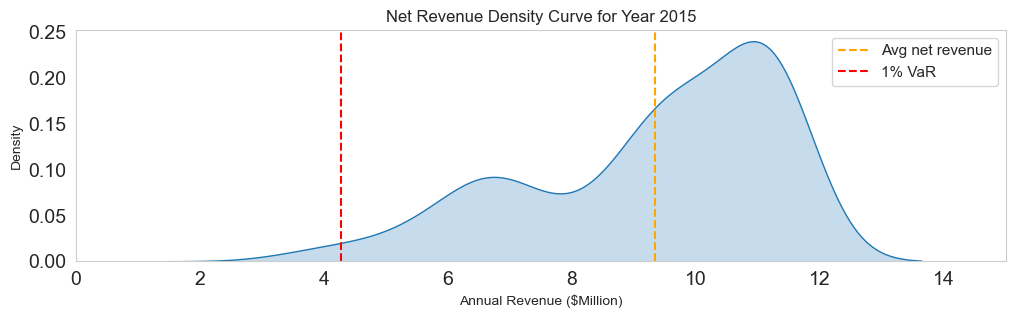

In [22]:
filtered_data = group_sorted[group_sorted['Year'] == 2024]

plt.figure(figsize=(12, 3))
sns.kdeplot(filtered_data['Annual Revenue'], fill=True)
plt.title("Net Revenue Density Curve for Year 2015")
plt.xlabel("Annual Revenue ($Million)")
plt.axvline(x=np.mean(filtered_data['Annual Revenue']), color='orange', linestyle='--', label='Avg net revenue')
print(f"Mean Annual Revenue: {np.mean(filtered_data['Annual Revenue'])}")

first_percentile = np.percentile(filtered_data['Annual Revenue'], 1)
print(f"1st Percentile Annual Revenue: {first_percentile}")
plt.axvline(x=first_percentile, color='red', linestyle='--', label='1% VaR')

plt.xlim(0, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(False)
plt.savefig('plots/net_revenue_density_curve_2024.png', dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Total Pumping')

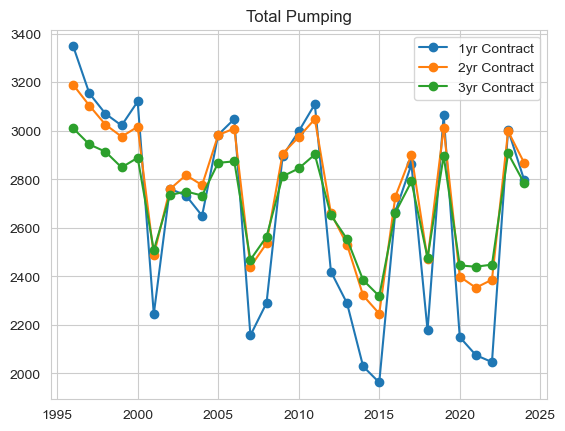

In [47]:
average_revenue_3y = revenue_3y.groupby(['Year','GroupNumber'])['Total Pumping'].mean()
average_revenue_3y = average_revenue_3y.reset_index()
filtered_1y = average_revenue_3y[average_revenue_3y['GroupNumber'] == 1]
filtered_2y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2)]
filtered_2y = filtered_2y.groupby(['Year']).mean().reset_index()
filtered_3y = average_revenue_3y[(average_revenue_3y['GroupNumber'] == 1) | (average_revenue_3y['GroupNumber'] == 2) | (average_revenue_3y['GroupNumber'] == 3)]
filtered_3y = filtered_3y.groupby(['Year']).mean().reset_index()
plt.plot(filtered_1y['Year'], filtered_1y['Total Pumping'], label = '1yr Contract', marker='o')
plt.plot(filtered_2y['Year'], filtered_2y['Total Pumping'], label = '2yr Contract', marker='o')
plt.plot(filtered_3y['Year'], filtered_3y['Total Pumping'], label = '3yr Contract', marker='o')
plt.legend()
plt.title('Total Pumping')

mean 2773.4900943424855
Strike: 2496.141084908237


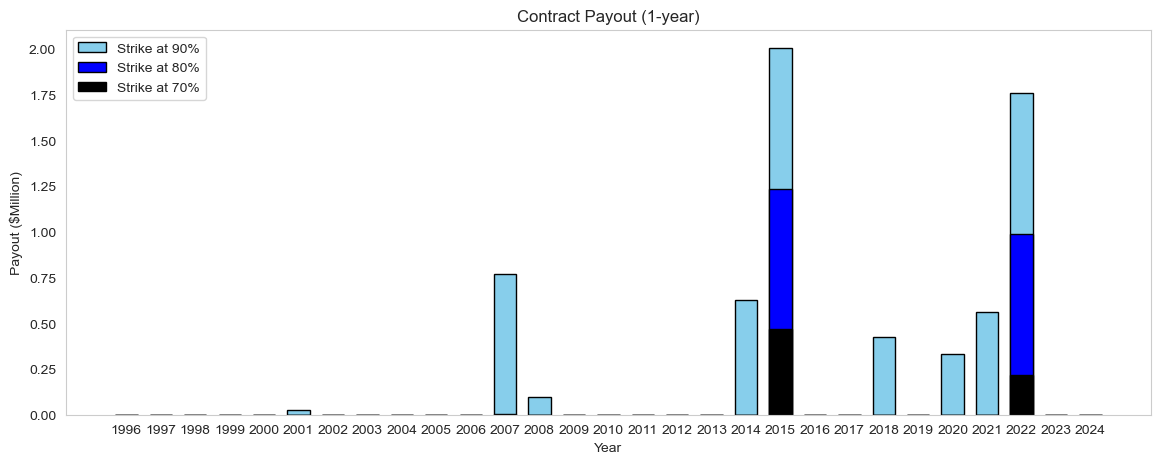

In [ ]:
slope = 0.002773398  #unit is million dollars per tAF
print("mean", mean_value)
strike_90 = 0.9 * mean_value   # should it be mean?
strike_80 = 0.8 * mean_value 
strike_70 = 0.7 * mean_value 
print("Strike:", strike_90)
payout_90 = slope * np.clip((strike_90 - medians), 0, None)
payout_80 = slope * np.clip((strike_80 - medians), 0, None)
payout_70 = slope * np.clip((strike_70 - medians), 0, None)
# payout = pd.DataFrame({'year':payout_75.index, 'payout':payout.values})
plt.figure(figsize=(14, 5))
bar_width = 0.65  

plt.bar(years, payout_90, width=bar_width, color='skyblue', edgecolor='black', label='Strike at 90%')
plt.bar(years, payout_80, width=bar_width, color='blue', edgecolor='black', label='Strike at 80%')
plt.bar(years, payout_70, width=bar_width, color='black', edgecolor='black', label='Strike at 70%')


plt.legend()
plt.title(f"Contract Payout (1-year)")
plt.xlabel('Year')
plt.ylabel('Payout ($Million)')
plt.xticks(years)  # X-ticks as years from the dictionary keys
plt.grid(False)
plt.show()

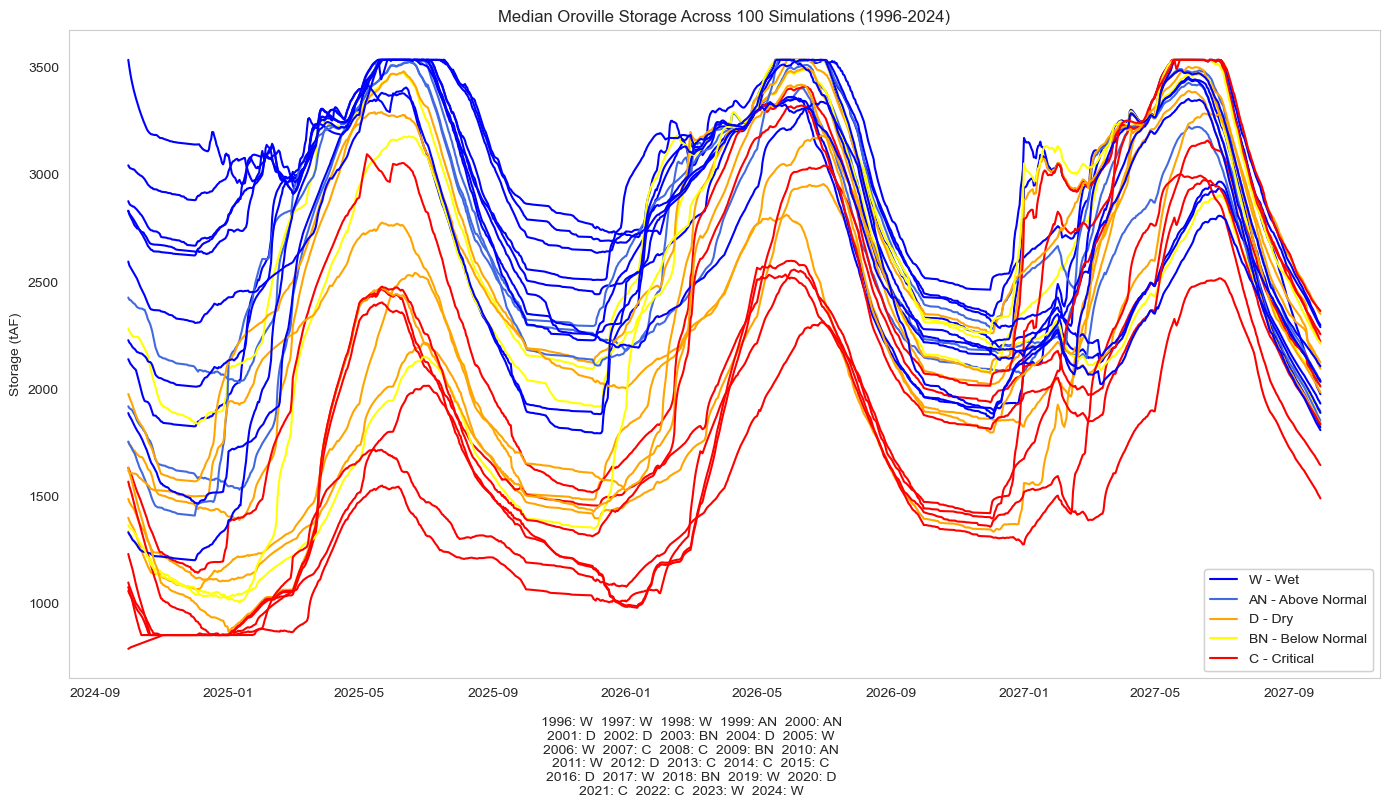

In [50]:
median_df = pd.DataFrame(yearly_traces)
plt.figure(figsize=(14, 8))

for i, year in enumerate(range(start_year, end_year + 1)):
    if year in median_df.columns:
        year_type = year_types[i]
        color = color_map[year_type]
        
        line = plt.plot(median_df[year], 
                 color=color, 
                 label=f'{year} ({year_type})')
        
        if year_type not in legend_handles:
            legend_handles[year_type] = line[0]

plt.title('Median Oroville Storage Across 100 Simulations (1996-2024)')
plt.ylabel('Storage (tAF)')
plt.grid(False)

first_legend = plt.legend(handles=list(legend_handles.values()), 
                         labels=[f"{k} - {type_names[k]}" for k in legend_handles.keys()],
                         loc='lower right')
plt.gca().add_artist(first_legend)

# Add a separate text annotation for the year mapping
years_text = ""
for i, year in enumerate(range(start_year, end_year + 1)):
    years_text += f"{year}: {year_types[i]}  "
    if (i+1) % 5 == 0:  # Line break every 5 years
        years_text += "\n"

plt.figtext(0.5, -0.05, years_text, ha='center')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for the text at the bottom
plt.show()


## autocorrelation time-series

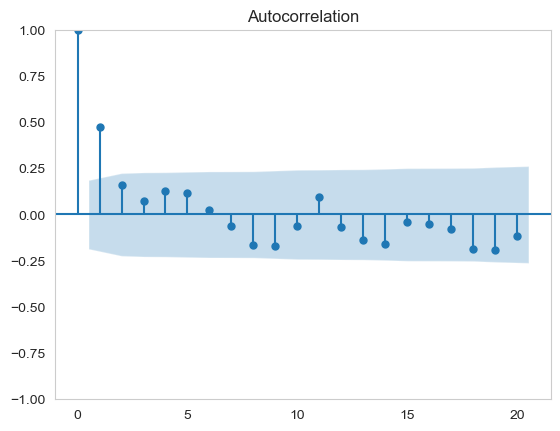

In [30]:
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#tranform to standard normal
yearly_pump_data_losthills_nd = (yearly_pump_data_losthills - yearly_pump_data_losthills.mean()) / yearly_pump_data_losthills.std()
plot_acf(yearly_pump_data_losthills_nd, lags=20)
plt.grid(False)
pyplot.show()

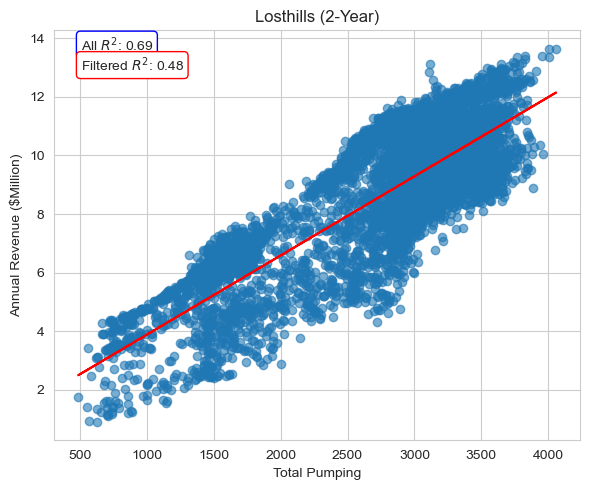

In [58]:
# Settings for 'losthills' for 3 years
district = 'losthills'
years_to_include = 2

fig, ax = plt.subplots(figsize=(6, 5))

x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)


mask_90 = x < strike_90
x_fit_90 = x[mask_90]
y_fit_90 = y[mask_90]
slope_90, intercept_90 = np.polyfit(x_fit_90, y_fit_90, 1)

mask_80 = x < strike_80
x_fit_80 = x[mask_80]
y_fit_80 = y[mask_80]
slope_80, intercept_80 = np.polyfit(x_fit_80, y_fit_80, 1)

mask_70 = x < strike_70
x_fit_70 = x[mask_70]
y_fit_70 = y[mask_70]
slope_70, intercept_70 = np.polyfit(x_fit_70, y_fit_70, 1)

line_fit = slope_90 * x + intercept_90

ax.scatter(x, y, alpha=0.6, label='All data')

ax.plot(x, line_fit, 'r-', label=f'Fit (y < {strike_90}): y={slope_90:.2f}x + {intercept_90:.2f}')

ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
ax.set_xlabel("Total Pumping")
ax.set_ylabel("Annual Revenue ($Million)")

# ax.set_ylim(0, 20)

corr_coef_all = np.corrcoef(x, y)[0, 1]
r_squared_all = corr_coef_all ** 2
ax.annotate(f"All $R^2$: {r_squared_all:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

# Calculate and display the correlation coefficient and R-squared for filtered data
corr_coef_filtered = np.corrcoef(x_fit_90, y_fit_90)[0, 1] if len(x_fit_90) > 1 else 0
r_squared_filtered = corr_coef_filtered ** 2 if len(x_fit_90) > 1 else 0
ax.annotate(f"Filtered $R^2$: {r_squared_filtered:.2f}", xy=(0.05, 0.90), xycoords='axes fraction',
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='r', facecolor='white'))

# ax.legend() 
plt.tight_layout()
plt.show()

In [13]:
print('strike_90', strike_90, 'strike_80', strike_80, 'strike_70', strike_70)

strike_90 2505.646262949155 strike_80 2227.2411226214713 strike_70 1948.835982293787


# basis risks (hsitorical data)

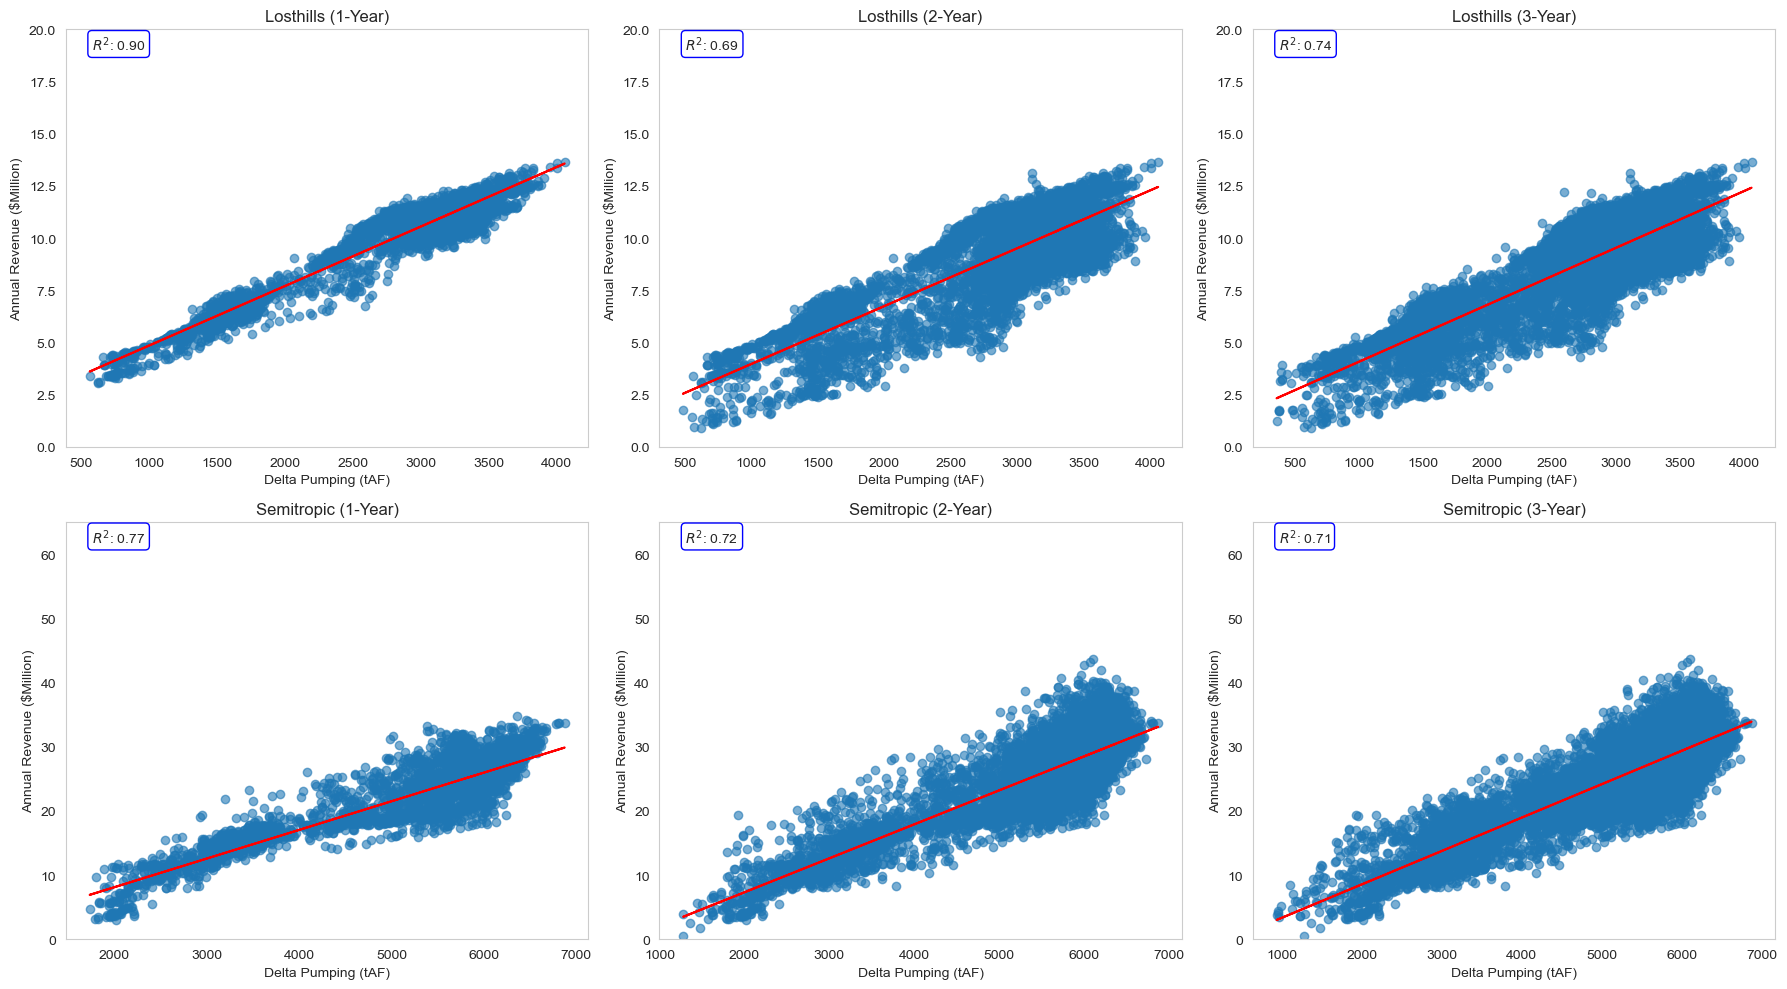

In [65]:

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 districts x 3 years

districts = ['losthills', 'semitropic']
years_to_include_opts = [1, 2, 3]
slopes_df = pd.DataFrame(columns=['District', 'Years', 'Slope'])

for i, district in enumerate(districts):
    for j, years_to_include in enumerate(years_to_include_opts):
        x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)

        slope, intercept = np.polyfit(x, y, 1)
        line = slope * x + intercept
        slopes_df = slopes_df.append({'District': district, 'Years': years_to_include, 'Slope': slope}, ignore_index=True)

        ax = axs[i, j]
        ax.scatter(x, y, alpha=0.6)
        ax.plot(x, line, 'r-', label=f'y={slope:.2f}x + {intercept:.2f}')
        ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
        ax.set_xlabel("Delta Pumping (tAF)")
        ax.set_ylabel("Annual Revenue ($Million)")
        ax.grid(False)

        # specific y limits for each district for better visualization
        if district == 'losthills':
            ax.set_ylim(0, 20)
        elif district == 'semitropic':
            ax.set_ylim(0, 65)

        corr_coef = np.corrcoef(x, y)[0, 1]
        r_squared = corr_coef ** 2
        ax.annotate(f"$R^2$: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.tight_layout()
plt.savefig("plots/contractPeriod_basis.png")
plt.show()

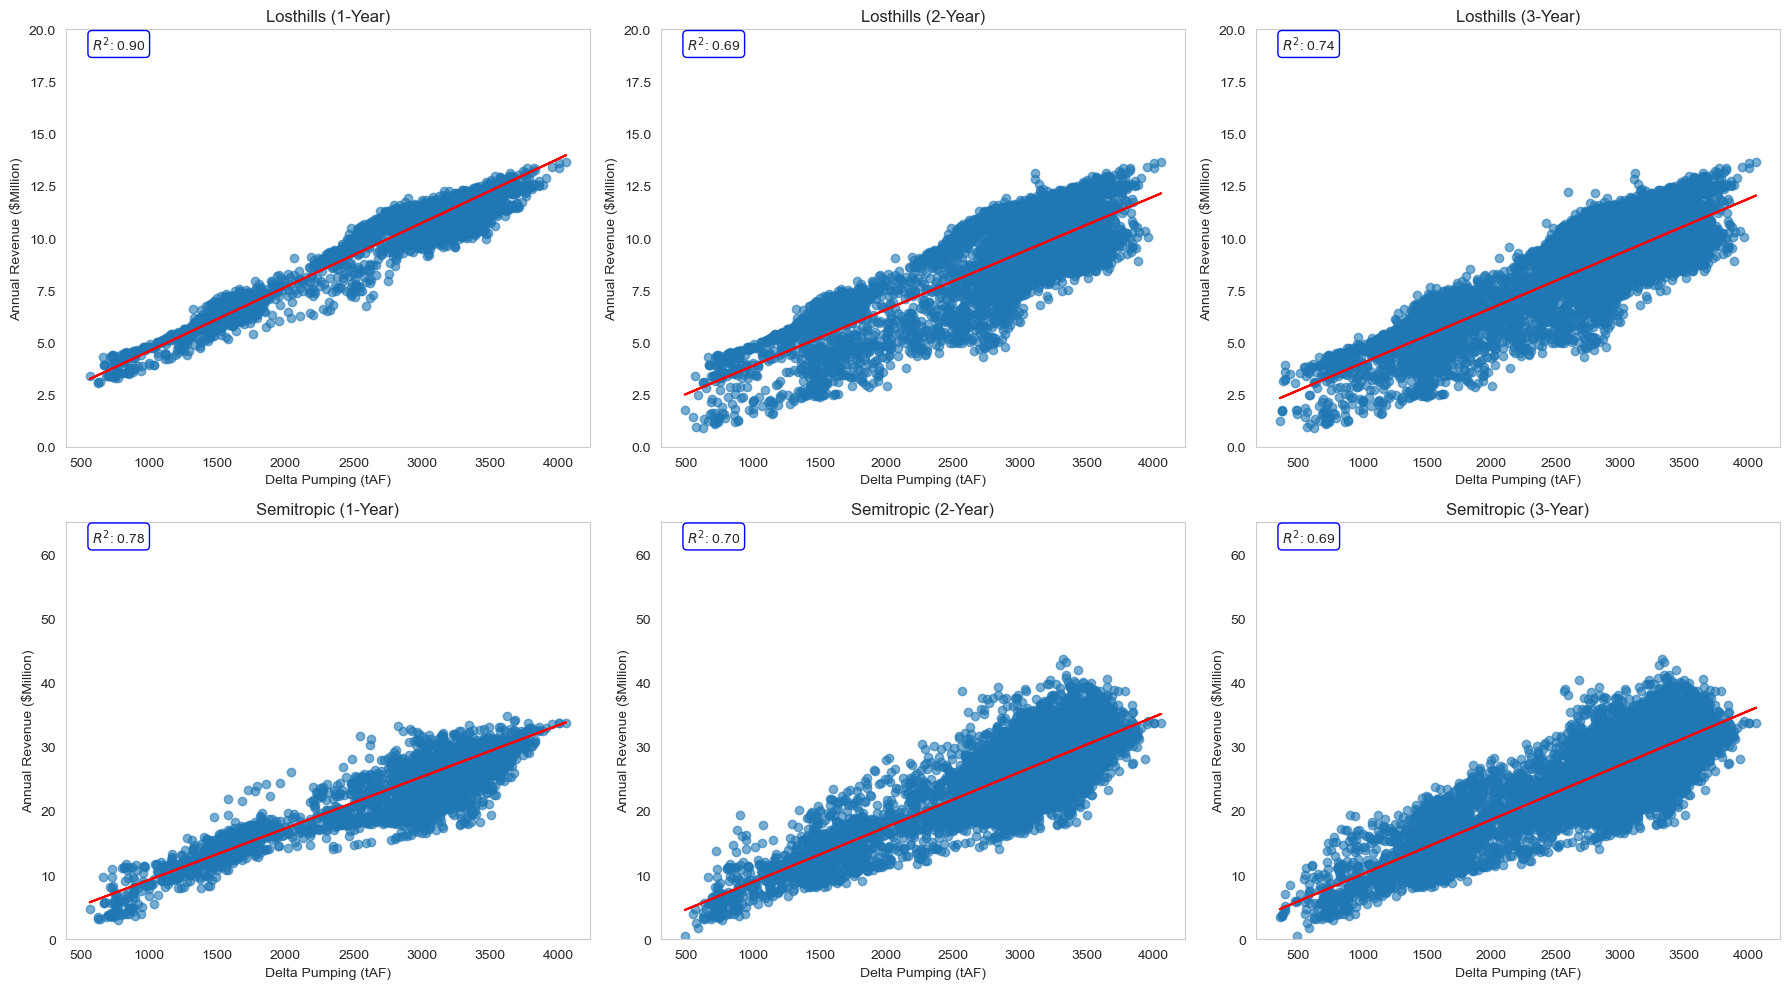

      District Years Strike_Level     Slope
0    losthills     1           90  0.003069
1    losthills     1           80  0.002962
2    losthills     1           70  0.003026
3    losthills     2           90  0.002700
4    losthills     2           80  0.002440
5    losthills     2           70  0.002651
6    losthills     3           90  0.002623
7    losthills     3           80  0.002493
8    losthills     3           70  0.002747
9   semitropic     1           90  0.008021
10  semitropic     1           80  0.009366
11  semitropic     1           70  0.009964
12  semitropic     2           90  0.008551
13  semitropic     2           80  0.009089
14  semitropic     2           70  0.009197
15  semitropic     3           90  0.008470
16  semitropic     3           80  0.009134
17  semitropic     3           70  0.009416


In [69]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 districts x 3 years

districts = ['losthills', 'semitropic']
years_to_include_opts = [1, 2, 3]
strike_levels = [90, 80, 70]

slopes_df = pd.DataFrame(columns=['District', 'Years', 'Strike_Level', 'Slope'])

for i, district in enumerate(districts):
    for j, years_to_include in enumerate(years_to_include_opts):
        x, y = analyze_correlation_between_pumping_and_revenue(district, years_to_include)

        for strike_level, strike_name in zip([strike_90, strike_80, strike_70], ['90', '80', '70']):
            # Create boolean mask and filter data below the strike level
            mask = x < strike_level
            x_fit = x[mask]
            y_fit = y[mask]

            if len(x_fit) > 1:
                slope, intercept = np.polyfit(x_fit, y_fit, 1)
            else:
                slope = np.nan  # Assign NaN if not enough data

            slopes_df = slopes_df.append({
                'District': district,
                'Years': years_to_include,
                'Strike_Level': strike_name,
                'Slope': slope
            }, ignore_index=True)

            # Decide whether to plot all strikes or just an aggregated view in plots
            if strike_level == strike_90:
                line = slope * x + intercept
                ax = axs[i, j]
                ax.scatter(x, y, alpha=0.6)
                ax.plot(x, line, 'r-', label=f'Fit (y < {strike_level}): {slope:.2f}' if not np.isnan(slope) else "N/A")
                ax.set_title(f"{district.capitalize()} ({years_to_include}-Year)")
                ax.set_xlabel("Delta Pumping (tAF)")
                ax.set_ylabel("Annual Revenue ($Million)")
                ax.grid(False)

                # Adjust y-axis limits for visualization
                if district == 'losthills':
                    ax.set_ylim(0, 20)
                elif district == 'semitropic':
                    ax.set_ylim(0, 65)

                # Annotate R-squared for the overall dataset
                corr_coef = np.corrcoef(x, y)[0, 1] if len(x) > 1 else 0
                r_squared = corr_coef ** 2
                ax.annotate(f"$R^2$: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
                            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.tight_layout()
plt.savefig("plots/contractPeriod_basis.png")
plt.show()

# Display the slopes DataFrame
print(slopes_df)

In [ ]:
# slopes_df.to_csv("results/slopes_df.csv", index=False)

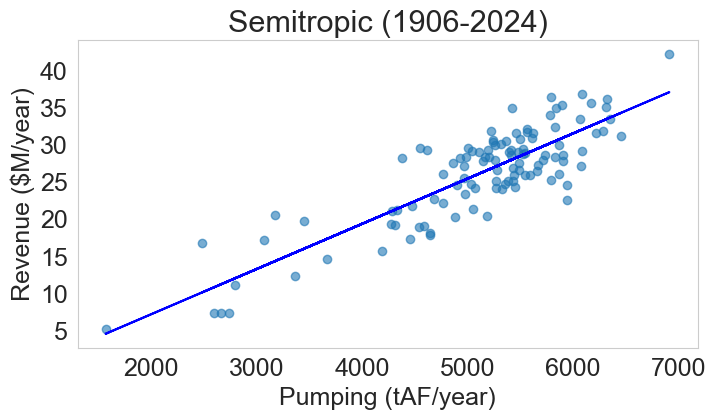

In [88]:
revenue_file = 'calfews_src/postprocess/semitropic_daily_revenue_110.csv'
semitropic_daily_revenue = pd.read_csv(revenue_file, index_col=0, parse_dates=True)
semitropic_Y_revenue = semitropic_daily_revenue.resample('AS-OCT').last()

daily_pump_data['total_pump'] = daily_pump_data['delta_HRO_pump'] + daily_pump_data['delta_TRP_pump']    # only get water from SWP (HRO)
yearly_pump_data = daily_pump_data.resample('AS-OCT').sum()
yearly_pump_data = yearly_pump_data['total_pump']
aligned_data = semitropic_Y_revenue.join(yearly_pump_data, how='inner')
x = aligned_data['total_pump']
y = aligned_data.iloc[:, 0]

# Calculate the linear fit
slope, intercept = np.polyfit(x, y, 1)
line = slope * x + intercept  # This is the line equation

# Plotting
plt.figure(figsize=(8, 4))
plt.scatter(x, y, alpha=0.6,)
plt.plot(x, line, 'b-', label=f'Fit line: y={slope:.2f}x + {intercept:.2f}')
plt.title(f"Semitropic (1906-2024)", fontsize=22)
plt.xlabel("Pumping (tAF/year)", fontsize = 18)
plt.ylabel("Revenue ($M/year)", fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(False)
# plt.legend()


# You can use numpy to calculate the correlation coefficient as a visual indicator
corr_coef = np.corrcoef(x, y)[0, 1]
# r_squared = corr_coef ** 2
# plt.annotate(f"Correlation: {r_squared:.2f}", xy=(0.05, 0.95), xycoords='axes fraction',
#              fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='b', facecolor='white'))

plt.show()

(array([ 1.,  0.,  0.,  2.,  3.,  1.,  2.,  2.,  0.,  1.,  7.,  9., 10.,
        17., 24., 13., 11.,  6.,  1.,  1.]),
 array([1573.35118775, 1840.18643345, 2107.02167915, 2373.85692485,
        2640.69217056, 2907.52741626, 3174.36266196, 3441.19790766,
        3708.03315337, 3974.86839907, 4241.70364477, 4508.53889047,
        4775.37413618, 5042.20938188, 5309.04462758, 5575.87987328,
        5842.71511898, 6109.55036469, 6376.38561039, 6643.22085609,
        6910.05610179]),
 <BarContainer object of 20 artists>)

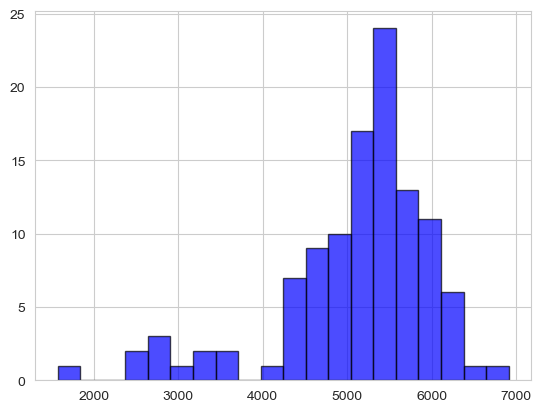

In [42]:
plt.hist(aligned_data['total_pump'], bins=20, color='blue', edgecolor='black', alpha=0.7)